In [68]:
# -*- coding:utf-8 -*-

import os
import sys
import random
import numpy as np
from six.moves import cPickle

class_num = 100
image_size = 32
img_channels = 3


# ========================================================== #
# ├─ prepare_data()
#  ├─ download training data if not exist by download_data()
#  ├─ load data by load_data()
#  └─ shuffe and return data
# ========================================================== #



def load_batch(fpath, label_key='labels'):
  """Internal utility for parsing CIFAR data.
  Arguments:
      fpath: path the file to parse.
      label_key: key for label data in the retrieve
          dictionary.
  Returns:
      A tuple `(data, labels)`.
  """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = cPickle.load(f)
  else:
    d = cPickle.load(f, encoding='bytes')
    # decode utf8
    d_decoded = {}
    for k, v in d.items():
      d_decoded[k.decode('utf8')] = v
    d = d_decoded
  f.close()
  data = d['data']
  labels = d[label_key]

  data = data.reshape(data.shape[0], 3, 32, 32)
  return data, labels


def load_data(label_mode='fine', path='./Data/cifar-100'):
  """Loads CIFAR100 dataset.
  Arguments:
      label_mode: one of "fine", "coarse".
  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
  Raises:
      ValueError: in case of invalid `label_mode`.
  """
  if label_mode not in ['fine', 'coarse']:
    raise ValueError('label_mode must be one of "fine" "coarse".')

  fpath = os.path.join(path, 'train')
  x_train, y_train = load_batch(fpath, label_key=label_mode + '_labels')

  fpath = os.path.join(path, 'test')
  x_test, y_test = load_batch(fpath, label_key=label_mode + '_labels')

  y_train = np.reshape(y_train, (len(y_train), 1))
  y_test = np.reshape(y_test, (len(y_test), 1))

  x_train = x_train.transpose(0, 2, 3, 1)
  x_test = x_test.transpose(0, 2, 3, 1)

  return (x_train, y_train), (x_test, y_test)


# ========================================================== #
# ├─ _random_crop()
# ├─ _random_flip_leftright()
# ├─ data_augmentation()
# └─ color_preprocessing()
# ========================================================== #

def _random_crop(batch, crop_shape, padding=None):
    oshape = np.shape(batch[0])

    if padding:
        oshape = (oshape[0] + 2 * padding, oshape[1] + 2 * padding)
    new_batch = []
    npad = ((padding, padding), (padding, padding), (0, 0))
    for i in range(len(batch)):
        new_batch.append(batch[i])
        if padding:
            new_batch[i] = np.lib.pad(batch[i], pad_width=npad,
                                      mode='constant', constant_values=0)
        nh = random.randint(0, oshape[0] - crop_shape[0])
        nw = random.randint(0, oshape[1] - crop_shape[1])
        new_batch[i] = new_batch[i][nh:nh + crop_shape[0],
                       nw:nw + crop_shape[1]]
    return new_batch


def _random_flip_leftright(batch):
    for i in range(len(batch)):
        if bool(random.getrandbits(1)):
            batch[i] = np.fliplr(batch[i])
    return batch


def color_preprocessing(x_train, x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train[:, :, :, 0] = (x_train[:, :, :, 0] - np.mean(x_train[:, :, :, 0])) / np.std(x_train[:, :, :, 0])
    x_train[:, :, :, 1] = (x_train[:, :, :, 1] - np.mean(x_train[:, :, :, 1])) / np.std(x_train[:, :, :, 1])
    x_train[:, :, :, 2] = (x_train[:, :, :, 2] - np.mean(x_train[:, :, :, 2])) / np.std(x_train[:, :, :, 2])

    x_test[:, :, :, 0] = (x_test[:, :, :, 0] - np.mean(x_test[:, :, :, 0])) / np.std(x_test[:, :, :, 0])
    x_test[:, :, :, 1] = (x_test[:, :, :, 1] - np.mean(x_test[:, :, :, 1])) / np.std(x_test[:, :, :, 1])
    x_test[:, :, :, 2] = (x_test[:, :, :, 2] - np.mean(x_test[:, :, :, 2])) / np.std(x_test[:, :, :, 2])

    return x_train, x_test


def data_augmentation(batch):
    batch = _random_flip_leftright(batch)
    batch = _random_crop(batch, [32, 32], 4)
    return np.array(batch, dtype=np.int32)

(x_train, y_train), (x_test, y_test) = load_data()
print(x_train.shape)


(50000, 32, 32, 3)


Train Data shape:  (50000, 32, 32, 3)
Train Label shape:  (50000, 1)
['seal']
(32, 32, 3)


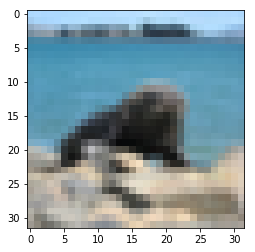

In [85]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict # return dic keys: [b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']

########## Data ##########
# Data format:
# data -- a 10000x3072 numpy array of uint8s. 
#         Each row of the array stores a 32x32 colour image. 
#         The first 1024 entries contain the red channel values, 
#         the next 1024 the green, and the final 1024 the blue. 
#         The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
# labels -- a list of 10000 numbers in the range 0-99. The number at index i indicates the label of the ith image in the array data.

# # Load training data
# train_set = unpickle('./Data/cifar-100/train')
# train_data = np.asarray(train_set[b'data'], dtype=np.float32) # shape (50000, 3072) 50000 images of 32x32x3 values
# train_labels = np.asarray(train_set[b'fine_labels'], dtype=np.int32)
# filenames = np.asarray(train_set[b'filenames'])

classes = unpickle('./Data/cifar-100/meta')
fine_class = np.asarray(classes[b'fine_label_names'], dtype=np.dtype(np.str))
coarse_class = np.asarray(classes[b'coarse_label_names'], dtype=np.dtype(np.str))

print('Train Data shape: ', x_train.shape)
print('Train Label shape: ', y_train.shape)

# plot a randomly chosen image
img = round(np.random.rand() * x_train.shape[0])
print(fine_class[y_train[img]])
train_data_img = x_train[img]
print(train_data_img.shape)
plt.imshow(train_data_img.astype("uint8"),interpolation='none')
plt.show()
########## Data ##########

(50, 32, 32, 3)


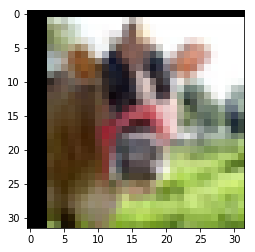

In [84]:
test = data_augmentation(x_train[:50])
print(test.shape)
plt.imshow(test[0].astype("uint8"),interpolation='none')
plt.show()